In [1]:
import numpy as np 
import torch 
from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split
import pandas as pd
from tqdm import tqdm

import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

c:\Program Files\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
#----------------------Load the Excel file-----------------------
def load_data(file_path, sheet_name):
    sheet_name = sheet_name
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    index_tensor = (df['A_position_counted_from_5_end_of_gRNA'] + 20).astype(int) 
    return df, index_tensor

In [58]:
import pandas as pd
import torch

class FeatureProcessor:
    def __init__(self, file_path='D:/01IscBML/', file_name = 'train.xlsx'):
        self.category_map = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
        self.data_path = file_path + file_name
        self.df, self.index_tensor = self.load_data(self.data_path)  # load the df and index tensor as self attributes
        self.combined_features, self.sequence_length = self.feature_processing()
        self.labels_tensor = self.label()

    def __len__(self):
        return len(self.df.shape[0])

    def load_data(self, data_path):
        df = pd.read_excel(data_path)
        index_tensor = (df['A_position_counted_from_5_end_of_gRNA'] + 20).astype(int)-1 # Warning: 0-indexed
        return df, index_tensor

    def sequence_to_one_hot(self, sequence, categories="ATCG"):
        category_map = {char: idx for idx, char in enumerate(categories)}
        one_hot = []
        for char in sequence:
            one_hot_char = [0] * len(categories)
            if char in category_map:
                one_hot_char[category_map[char]] = 1
            one_hot.append(one_hot_char)
        return one_hot

    def feature_processing(self):
        sequence_data = self.df['Target_Site_sequence']
        sequence_length = len(sequence_data.iloc[0])
        one_hot_features = sequence_data.apply(self.sequence_to_one_hot)

        features_tensor = torch.tensor(list(one_hot_features), dtype=torch.float32)

        index_one_hot_features = []
        for idx in self.index_tensor:
            index_one_hot = [0] * sequence_length
            if 0 <= idx < sequence_length:
                index_one_hot[idx] = 1
            index_one_hot_features.append(index_one_hot)

        index_one_hot_tensor = torch.tensor(index_one_hot_features, dtype=torch.float32).unsqueeze(2)

        combined_features = torch.cat((features_tensor, index_one_hot_tensor), dim=2)
        return combined_features, sequence_length
    
    def label(self):
        #---------------------Prepare labels tensor-----------------------
        labels_tensor = torch.tensor(self.df['a-to-g(%)'].values/100, dtype=torch.float32).unsqueeze(1)  # Add a dimension for labels
        return labels_tensor
    



In [59]:
label_data = FeatureProcessor(file_path='D:/01IscBML/').labels_tensor
combined_features = FeatureProcessor(file_path='D:/01IscBML/').combined_features

In [5]:
sequence_length = FeatureProcessor(file_path='D:/01IscBML/').sequence_length

In [34]:
sequence_length

56

In [60]:
#---------------------Prepare labels tensor-----------------------
# labels_tensor = torch.tensor(df['a-to-g(%)'].values/100, dtype=torch.float32).unsqueeze(1)  # Add a dimension for labels

#---------------------Create dataset and dataloader-----------------
dataset = TensorDataset(combined_features, label_data)

# Turn shuffle to False if you want to keep the predefined order of the data
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)  # You can adjust the batch size as needed
i= 0
# #----------------------Example to check batches---------------------
# for i, (batch_features, batch_labels) in enumerate(dataloader):
#     print("Batch", i)
#     print("Features Batch Shape:", batch_features[20,20:36,:])  # (batch_size, sequence_length, channel_size)
#     print("Labels Batch Shape:", batch_labels[20])  # (batch_size, 1)
#     i+=1
#     if i == 2:
#         break


In [36]:
# Define a simple 1D CNN model
# class CNN(nn.Module):
#     def __init__(self, sequence_length):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=5, out_channels=16, kernel_size=3, padding=1)  # Update in_channels to 5
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool1d(kernel_size=2)
        
#         # Dynamically compute the size of the flattened feature map
#         self.flattened_size = 16 * (sequence_length // 2)  # After one max pooling (sequence_length // 2)
#         self.fc1 = nn.Linear(self.flattened_size, 1)  # Fully connected layer
        
#     def forward(self, x):
#         x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, sequence_length)
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)  # Flatten
#         x = self.fc1(x)
#         return x

# class OptimizedCNN(nn.Module):
#     def __init__(self, sequence_length):
#         super(OptimizedCNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=5, out_channels=16, kernel_size=3, padding=1)  # 卷积层
#         self.relu = nn.ReLU()
        
#         # 计算全连接层输入的维度
#         self.flattened_size = 16 * sequence_length  # 无池化层时，序列长度不变
#         self.fc1 = nn.Linear(self.flattened_size, 1)  # 全连接层

#     def forward(self, x):
#         x = x.permute(0, 2, 1)  # 调整维度为 (batch_size, channels, sequence_length)
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = x.view(x.size(0), -1)  # 展平
#         x = self.fc1(x)
#         return x

In [61]:
class LocalCNN(nn.Module):
    def __init__(self, sequence_length, kernel_size=21):
        super(LocalCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=32, kernel_size=kernel_size, padding=kernel_size // 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32 * sequence_length, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, sequence_length)
        x = self.conv1(x)  # Apply convolution
        x = self.relu(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class MLP(nn.Module):
    def __init__(self, sequence_length):
        super(MLP, self).__init__()
        input_size = sequence_length * 5  # Flattened input size
        hidden_size = 512  # Number of neurons in each hidden layer
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),  # Add dropout for regularization
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1),  # Final output layer
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input to (batch_size, sequence_length * 5)
        x = self.layers(x)
        # x = torch.sigmoid(x)
        return x

In [62]:
#------------------split train&validation dataset---------------------
from torch.utils.data import random_split, DataLoader

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size) 
val_size = dataset_size - train_size  
print(val_size)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_size, shuffle=False) 



5576


In [ ]:
import time
# Initialize the model, loss function, and optimizer
model = MLP(sequence_length = sequence_length)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation setup
num_epochs = 100  # Adjust as needed

# Function to calculate Pearson correlation coefficient
def pearson_correlation(predicted, actual):
    pred_mean = predicted.mean()
    actual_mean = actual.mean()
    covariance = ((predicted - pred_mean) * (actual - actual_mean)).sum()
    pred_std = ((predicted - pred_mean) ** 2).sum().sqrt()
    actual_std = ((actual - actual_mean) ** 2).sum().sqrt()
    return (covariance / (pred_std * actual_std)).item()

plot_loss = []
plot_pearson = []
max_r = 0.0
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    train_pearson = 0.0  # To accumulate Pearson correlation coefficient for training
    
    # Training loop
    for batch_features, batch_labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move data to appropriate device (e.g., GPU if available)
        batch_features, batch_labels = batch_features.to('cpu'), batch_labels.to('cpu')
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate Pearson correlation for the batch
        predicted = outputs.squeeze(1)  # Remove singleton dimension
        actual = batch_labels.squeeze(1)
        train_pearson += pearson_correlation(predicted, actual)

    # Compute average training loss and Pearson correlation for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    plot_loss.append(epoch_loss)
    epoch_train_pearson = train_pearson / len(train_dataloader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_pearson = 0.0
    with torch.no_grad():
        for val_features, val_labels in val_dataloader:  # Use a separate validation DataLoader
            val_features, val_labels = val_features.to('cpu'), val_labels.to('cpu')
            
            val_outputs = model(val_features)
            predicted = val_outputs.squeeze(1)
            # print(predicted)
            actual = val_labels.squeeze(1)
            # print(actual)

            # Calculate Pearson correlation for the validation set
            val_pearson += pearson_correlation(predicted, actual)
    
    # Compute average validation Pearson correlation for the epoch
    epoch_val_pearson = val_pearson / len(val_dataloader)
    plot_pearson.append(epoch_val_pearson)

    ##save the model
    if epoch_val_pearson > max_r:
        max_r = epoch_val_pearson
        save_model_path = f'D:/01IscBML/model_save.pth'
        torch.save(model.state_dict(), save_model_path)
    print(f"Model saved with Pearson correlation: {max_r:.4f}")

    # Print training and validation metrics
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Training Loss: {epoch_loss:.4f}")
    print(f"Validation Pearson Correlation: {epoch_val_pearson:.4f}")

plt.figure()
# plt.switch_backend('agg')
fig, ax1 = plt.subplots()

# model.predict()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='r')
ax1.plot(range(num_epochs), plot_loss, 'r', label='Training loss')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.set_ylabel('Validation Pearson Correlation', color='b')
ax2.plot(range(num_epochs), plot_pearson, 'b', label='Validation Pearson Correlation')
ax2.tick_params(axis='y', labelcolor='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
# plt.show()
plt.savefig('loss_plot_MLP.png')


Epoch 1/100:   0%|          | 0/88 [00:00<?, ?it/s]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
#------------------test dataset---------------------
from torch.utils.data import random_split, DataLoader

test_label_data = FeatureProcessor(file_path='D:/01IscBML/',file_name='test.xlsx').labels_tensor
test_combined_features = FeatureProcessor(file_path='D:/01IscBML/',file_name='test.xlsx').combined_features
#---------------------Create dataset and dataloader-----------------
dataset = TensorDataset(test_combined_features, test_label_data)
testset_length = len(dataset)
print(testset_length)

# Turn shuffle to False if you want to keep the predefined order of the data
test_dataloader = DataLoader(dataset, batch_size=testset_length, shuffle=False) 



6969


In [88]:

import torch
import pandas as pd

# Set the model to evaluation mode
model.eval()

# Initialize variables for tracking
test_results = []  # To store results for each test sample
test_pearson = 0.0

with torch.no_grad():  # Disable gradient computation for evaluation
    for test_features, test_labels in test_dataloader:  # Use the test DataLoader
        # Move data to the appropriate device (e.g., CPU)
        test_features, test_labels = test_features.to('cpu'), test_labels.to('cpu')
        
        # Perform predictions
        test_outputs = model(test_features)
        predicted = test_outputs.squeeze(1)  # Detach to numpy for processing
        actual = test_labels.squeeze(1)

        # Store each prediction with its actual label
        for pred, act in zip(predicted, actual):
            test_results.append({'Predicted': pred.item(), 'Actual': act.item()})
        
        # Calculate Pearson correlation for this batch
        test_pearson += pearson_correlation(predicted, actual)

# Compute average test Pearson correlation
avg_test_pearson = test_pearson / len(test_dataloader)
print(f"Average Test Pearson Correlation: {avg_test_pearson}")

# Save test results to a DataFrame and export to a CSV file
results_df = pd.DataFrame(test_results)
results_df.to_csv('test_results1.csv', index=False)
print("Test results saved to 'test_results.csv'.")


Average Test Pearson Correlation: -0.007576680742204189
Test results saved to 'test_results.csv'.


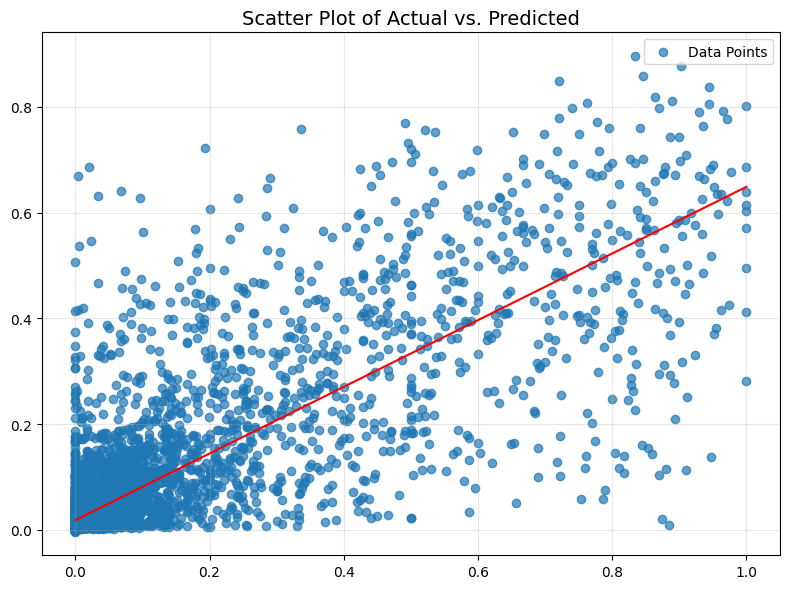

In [87]:
##draw the correlation plot
import matplotlib.pyplot as plt

# Example data: Replace these with your lists
test_results = pd.read_csv('test_results1.csv')
actual = test_results['Actual'].values
predicted = test_results['Predicted'].values

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(actual, predicted, alpha=0.7, label='Data Points')
plt.plot(np.unique(actual), np.poly1d(np.polyfit(actual,predicted,1))
         (np.unique(actual)), color='red')

# Add a perfect correlation line
# min_val = min(min(actual), min(predicted))
# max_val = max(max(actual), max(predicted))

# Add labels, title, legend, and grid
plt.title('Scatter Plot of Actual vs. Predicted', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# # Define a simple 1D CNN model
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
#         self.relu = nn.ReLU()
#         self.pool = nn.MaxPool1d(kernel_size=2)
#         self.fc1 = nn.Linear(16 * (56 // 2), 1)  # Assuming sequence length is 56 after pooling
        
#     def forward(self, x):
#         x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, sequence_length)
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)  # Flatten
#         x = self.fc1(x)
#         return x

In [ ]:
"""class dataloader

class IscBDataset(Dataset):
    def __init__(self):
        super(IscBDataset,self).__init__()
        xy = truncated_simple_df.to_numpy(dtype=np.float64)[:,1:]
        self.x = torch.from_numpy(xy[0]) #convert numpy into torch tensor
        self.y = torch.from_numpy(xy[1])
        ###for scaler standardize features
        # self.scaler = StandardScaler()  #standardized_value = (value - mean)/standard deviation
        # self.x = torch.from_numpy(self.scaler.fit_transform(self.x))
        self.n_samples = len(xy)

    def __getitem__(self, index) :
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

dataset = IscBDataset()
data_Loader = DataLoader(dataset=dataset, shuffle = True) #(batch_size = batch_size)

"""

'class dataloader\n\nclass IscBDataset(Dataset):\n    def __init__(self):\n        super(IscBDataset,self).__init__()\n        xy = truncated_simple_df.to_numpy(dtype=np.float64)[:,1:]\n        self.x = torch.from_numpy(xy[0]) #convert numpy into torch tensor\n        self.y = torch.from_numpy(xy[1])\n        ###for scaler standardize features\n        # self.scaler = StandardScaler()  #standardized_value = (value - mean)/standard deviation\n        # self.x = torch.from_numpy(self.scaler.fit_transform(self.x))\n        self.n_samples = len(xy)\n\n    def __getitem__(self, index) :\n        return self.x[index], self.y[index]\n\n    def __len__(self):\n        return self.n_samples\n\ndataset = IscBDataset()\ndata_Loader = DataLoader(dataset=dataset, shuffle = True) #(batch_size = batch_size)\n\n'